In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
import re
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim
import pyLDAvis
from gensim.models import CoherenceModel
import seaborn as sns
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gsevr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_holc = pd.read_csv('holc_output.csv')
df_comm = pd.read_csv('comments.csv', delimiter=';')

df = pd.concat([df_comm, df_holc], axis=1)

df.drop(df.columns[1],axis=1,inplace=True)
df.drop(df.columns[1],axis=1,inplace=True)

df['unic_sentiment'] = df.unic_sentiment.apply(lambda x: 'Positive Sentiment' if x == 'pos' else 'Negative Sentiment' if x == 'neg' else 'Neutral Sentiment')
df

,comment,unic_sentiment,unic_score
0,it is very possible that social media have alr...,Negative Sentiment,0.97
1,@paul i believe that accurate beliefs are abso...,Positive Sentiment,0.89
2,@chris v our cognitive systems are not designe...,Negative Sentiment,0.88
3,@paul absolutely agree. i don’t think even lib...,Negative Sentiment,0.92
4,@paul belief is a a trait that developed late ...,Negative Sentiment,0.91
...,...,...,...
1443,purdue pharma's sackler family paid $6 billion...,Neutral Sentiment,0.64
1444,"unless prevented, the nihilistic qualities of ...",Neutral Sentiment,0.69
1445,"putting ""the"" government in charge of things i...",Negative Sentiment,0.55
1446,this is just another example of 'extinction by...,Negative Sentiment,0.51


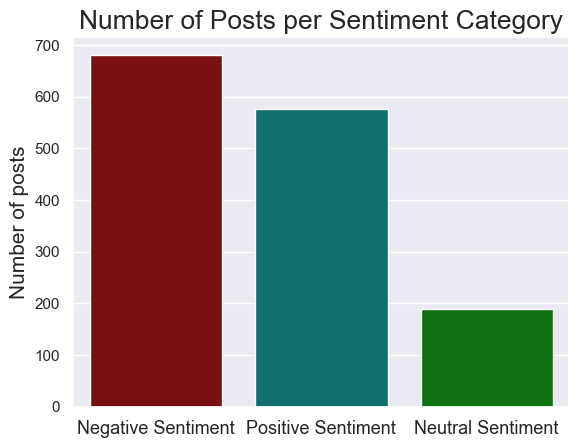

In [3]:
sns.set_theme()
fig, ax = plt.subplots()

a = pd.DataFrame(df.unic_sentiment.value_counts())


# plt.figure(figsize=(10,8))
sns.barplot(pd.DataFrame(df.unic_sentiment.value_counts()),x = a.index, y='count',palette=['darkred','teal','green'])
plt.title('Number of Posts per Sentiment Category',fontdict=dict(size=19))
plt.xlabel('')
plt.ylabel('Number of posts',fontdict=dict(size=15))
plt.xticks(fontsize=13)


plt.show()

In [4]:
def preprocess(text):
    t = text.lower()
    # t = re.sub('_',r'',t)
    # t = re.sub('\d+',r'',t)
    t = re.sub(r'@[^ ]*',r'',t)
    t = re.sub(r'\W+',r' ',t)
    t = re.sub(r'(could|would|like|)', '', t)
    t = re.sub(r'\b(?!(?:ai)\b)\w{3}\b','', t)
    t = re.sub(r'humans',r'human',t)
    stopwords_list = stopwords.words('english')
    txt = ' '.join([word for word in t.split() if word not in stopwords_list])
    return txt

lemmatizer = WordNetLemmatizer()



df['pre_com'] = [' '.join([lemmatizer.lemmatize(preprocess(email))])
                 .strip() for email in df['comment']]

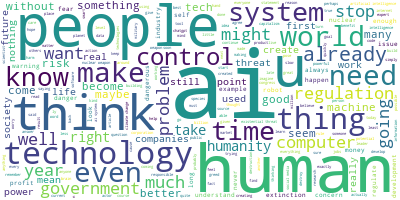

In [5]:
long_string = ','.join(list(df.pre_com.values))

wordcloud = WordCloud(background_color="white", max_words=250, contour_width=3, contour_color='steelblue')

wordcloud.generate(long_string)

wordcloud.to_image()

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = df.pre_com.values.tolist()
data_words = list(sent_to_words(data))
        

In [7]:
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [8]:
num_topics = 4

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=8
                                       )

pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

[(0,
  '0.031*"ai" + 0.008*"human" + 0.005*"people" + 0.005*"us" + '
  '0.004*"technology" + 0.004*"think" + 0.004*"need" + 0.003*"threat" + '
  '0.003*"world" + 0.003*"make"'),
 (1,
  '0.019*"ai" + 0.012*"human" + 0.007*"us" + 0.006*"people" + '
  '0.005*"technology" + 0.005*"stop" + 0.005*"even" + 0.004*"think" + '
  '0.004*"make" + 0.003*"world"'),
 (2,
  '0.026*"ai" + 0.010*"human" + 0.007*"us" + 0.006*"technology" + '
  '0.004*"government" + 0.004*"want" + 0.004*"people" + 0.004*"world" + '
  '0.004*"even" + 0.004*"systems"'),
 (3,
  '0.011*"people" + 0.010*"ai" + 0.010*"us" + 0.008*"think" + 0.008*"human" + '
  '0.004*"make" + 0.003*"technology" + 0.003*"already" + 0.003*"much" + '
  '0.003*"tech"')]


In [9]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'test_html.html')

c:\Python311\Lib\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [10]:
lambd = 0.3 # a specific relevance metric value

all_topics = {}
num_topics = lda_model.num_topics 
num_terms = 10 

for i in range(1,num_topics+1): ## Correct range
    topic = vis.topic_info[vis.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
all_df = pd.DataFrame(all_topics)

all_df

,Topic 1,Topic 2,Topic 3,Topic 4
0,ai,people,ai,stop
1,government,think,problem,human
2,want,us,unplug,chatgpt
3,human,change,maybe,ai
4,systems,earth,need,china
5,technology,kill,artificial,even
6,risk,next,threat,intelligence
7,world,leaders,intelligence,matrix
8,used,going,thought,russia
9,us,much,profiles,energy


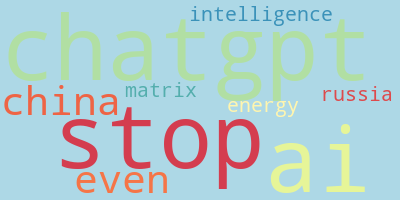

In [11]:
string = ','.join(list(all_df.iloc[:,3].values))
wordcloud = WordCloud(background_color="lightblue", colormap='Spectral', max_words=250, contour_width=3, contour_color='steelblue', stopwords=['human'])
wordcloud.generate(string)
wordcloud.to_file('wc_new'+str(3)+'.png')
wordcloud.to_image()

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.466416718770962

Coherence Score:  0.550914592376665


In [13]:
expdf = pd.read_csv('final_comms.csv')

In [14]:
testdf = pd.concat([df.iloc[:len(expdf),:],expdf],axis=1)

In [15]:
testdf['time'] = pd.to_datetime(testdf['time'],format='%Y-%m-%d %H:%M:%S')

In [16]:
testdf.rename(columns={'unic_sentiment':'Sentiment','unic_score':'confidence'},inplace=True)

Text(0.5, 1.0, 'Number of replies based on sentiment over time')

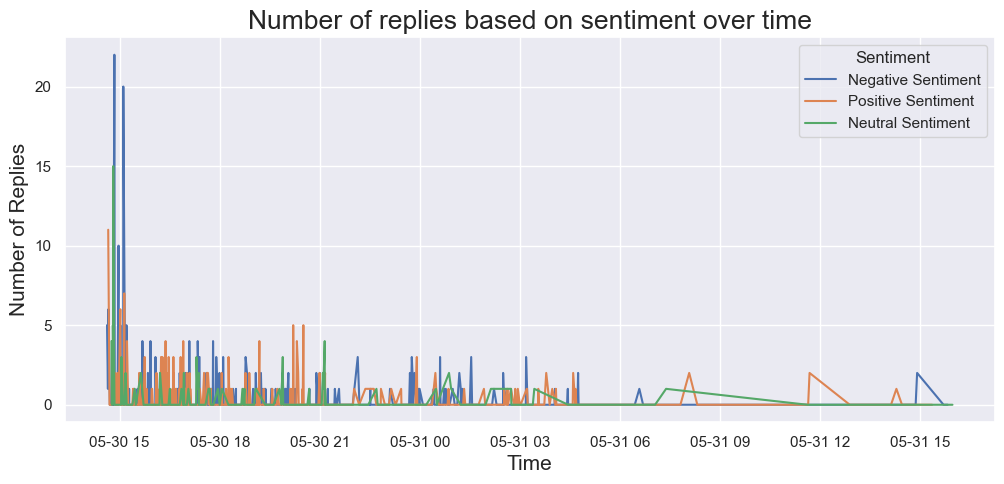

In [17]:
plt.figure(figsize=(12,5))
sns.lineplot(testdf,x='time',y='rep_count',hue='Sentiment')
plt.xlabel('Time',fontdict=dict(size=15))
plt.ylabel('Number of Replies',fontdict=dict(size=15))
plt.title('Number of replies based on sentiment over time',fontdict=dict(size=19))

In [18]:
expdf

,Unnamed: 0,comment_id,name,location,comment,time,likes,rep_count,replies,parent_id,pre_com,topic
0,0,125405146,Paul,Milwaukee,It is very possible that social media have alr...,2023-05-30 14:37:15,522,5,"[{'commentID': 125405281, 'status': 'approved'...",0,possible social media already cost us american...,2
1,1,125405281,Chris V,Detroit,@Paul I believe that accurate beliefs are abso...,2023-05-30 14:46:32,61,0,[],125405146,believe accurate beliefs absolutely necessary ...,0
2,2,125405707,Paul,Milwaukee,@Chris V Our cognitive systems are not designe...,2023-05-30 15:11:42,22,0,[],125405281,v cognitive systems designed natural selection...,0
3,3,125413598,Chris Burks,"Mount Vernon, WA",@Paul \nAbsolutely agree. I don’t think even l...,2023-05-30 20:37:47,12,0,[],125405146,absolutely agree think even liberal educated p...,0
4,4,125413969,L Kim,Seattle,@Paul Belief is a a trait that developed late ...,2023-05-30 20:53:27,1,0,[],125405146,belief trait developed late evolution necessary,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1443,1443,125431033,C,"N.,Y,",Purdue Pharma's Sackler family paid $6 billion...,2023-05-31 15:57:59,218,0,[],0,purdue pharma sackler family paid 6 billion do...,1
1444,1444,125430839,RjW,RollingPrairie,"Unless prevented, the nihilistic qualities of ...",2023-05-31 15:48:57,39,0,[],0,unless prevented nihilistic qualities currentl...,0
1445,1445,125428441,LB,U.S.,"Putting ""the"" government in charge of things i...",2023-05-31 13:27:24,100,0,[],0,putting government charge things hardly soluti...,4
1446,1446,125426057,JL Turriff,Concordia MO,This is just another example of 'extinction by...,2023-05-31 06:16:50,157,0,[],0,another example extinction stupidity much glob...,4


In [19]:
testdf

,comment,Sentiment,confidence,pre_com,Unnamed: 0,comment_id,name,location,comment,time,likes,rep_count,replies,parent_id,pre_com,topic
0,it is very possible that social media have alr...,Negative Sentiment,0.97,possible social media already cost us american...,0,125405146,Paul,Milwaukee,It is very possible that social media have alr...,2023-05-30 14:37:15,522,5,"[{'commentID': 125405281, 'status': 'approved'...",0,possible social media already cost us american...,2
1,@paul i believe that accurate beliefs are abso...,Positive Sentiment,0.89,believe accurate beliefs absolutely necessary ...,1,125405281,Chris V,Detroit,@Paul I believe that accurate beliefs are abso...,2023-05-30 14:46:32,61,0,[],125405146,believe accurate beliefs absolutely necessary ...,0
2,@chris v our cognitive systems are not designe...,Negative Sentiment,0.88,v cognitive systems designed natural selection...,2,125405707,Paul,Milwaukee,@Chris V Our cognitive systems are not designe...,2023-05-30 15:11:42,22,0,[],125405281,v cognitive systems designed natural selection...,0
3,@paul absolutely agree. i don’t think even lib...,Negative Sentiment,0.92,absolutely agree think even liberal educated p...,3,125413598,Chris Burks,"Mount Vernon, WA",@Paul \nAbsolutely agree. I don’t think even l...,2023-05-30 20:37:47,12,0,[],125405146,absolutely agree think even liberal educated p...,0
4,@paul belief is a a trait that developed late ...,Negative Sentiment,0.91,belief trait developed late evolution necessary,4,125413969,L Kim,Seattle,@Paul Belief is a a trait that developed late ...,2023-05-30 20:53:27,1,0,[],125405146,belief trait developed late evolution necessary,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,purdue pharma's sackler family paid $6 billion...,Neutral Sentiment,0.64,purdue pharma sackler family paid 6 billion do...,1443,125431033,C,"N.,Y,",Purdue Pharma's Sackler family paid $6 billion...,2023-05-31 15:57:59,218,0,[],0,purdue pharma sackler family paid 6 billion do...,1
1444,"unless prevented, the nihilistic qualities of ...",Neutral Sentiment,0.69,unless prevented nihilistic qualities currentl...,1444,125430839,RjW,RollingPrairie,"Unless prevented, the nihilistic qualities of ...",2023-05-31 15:48:57,39,0,[],0,unless prevented nihilistic qualities currentl...,0
1445,"putting ""the"" government in charge of things i...",Negative Sentiment,0.55,putting government charge things hardly soluti...,1445,125428441,LB,U.S.,"Putting ""the"" government in charge of things i...",2023-05-31 13:27:24,100,0,[],0,putting government charge things hardly soluti...,4
1446,this is just another example of 'extinction by...,Negative Sentiment,0.51,another example extinction stupidity much glob...,1446,125426057,JL Turriff,Concordia MO,This is just another example of 'extinction by...,2023-05-31 06:16:50,157,0,[],0,another example extinction stupidity much glob...,4


In [24]:
import plotly.express as px
import plotly.graph_objects as go

layout = go.Layout(title='Number of Replies per Sentiment Category over time',
                   xaxis_title='Time',
                   yaxis_title='Number of Replies')


fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=testdf[testdf.Sentiment == 'Positive Sentiment'].time.sort_values(), y=testdf[testdf.Sentiment == 'Positive Sentiment'].rep_count,
                    mode='lines',
                    name='Positive Sentiment',line=dict(color='teal'))
             )

fig.add_trace(go.Scatter(x=testdf[testdf.Sentiment == 'Negative Sentiment'].time.sort_values(), y=testdf[testdf.Sentiment == 'Negative Sentiment'].rep_count,
                    mode='lines',
                    name='Negative Sentiment',line=dict(color='darkred'))
)

fig.add_trace(go.Scatter(x=testdf[testdf.Sentiment == 'Neutral Sentiment'].time.sort_values(), y=testdf[testdf.Sentiment == 'Neutral Sentiment'].rep_count,
mode='lines',
name='Neutral Sentiment',line=dict(color='green'))
)


fig.update_xaxes(rangeslider_visible=True)


fig.show()

fig.write_html('sentiment_time_series.html')